In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import seaborn as sb
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from numba import vectorize
import unidecode
from nltk.corpus import stopwords
import time
import spacy
import re
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

from sklearn.decomposition import LatentDirichletAllocation

import mglearn as mglearn

%matplotlib inline

import string,lxml,bs4,nltk
from warnings import simplefilter

# 0- Functions & Definitions

#### Variables

In [103]:
contractions = {
"ain't": "are not",
"aren't": "am not",
"can't": "can not",
"can't've": "can not have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I had",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

#### Function: to load file

In [104]:
#This function will load file and return it as Data Frame and also return list of column names
def loadFile(fileName):
    #reading the temp file to a dataframe with the new headers    
    print('Loading File...',end='')
    result = pd.read_csv(fileName)
    print('[ok]')
    print('Loaded {:,} reviews' .format(len(result)))    
    print('Column Names: ', result.columns.tolist())
    return result, result.columns.tolist()

#### Function: to drop unused columns

In [105]:
#This fuction will return modified dataframe with selected columns only
def neededColumnsOnly(df, columns_needed):
    #return df.filter(columns_needed) 
    #Or
    to_drop_columns = list(x for x in df.columns.tolist() if x not in columns_needed)
    df.drop(to_drop_columns,axis=1,inplace=True)
    return df

#### Function: to find columns containing nulls

In [106]:
#This fuction will check which columns having null values
def columns_with_nulls(df, index_column):
    null_columns = []
    for column in df.columns:
        if column != index_column:
            check_null = df.isnull()[[column,index_column]].groupby(column).agg('count')
            try:
                if check_null.loc[True][0] > 0:
                    null_columns.append(column)
            except:
                pass
    return null_columns

#### Function: to remove all null values from columns

In [107]:
#This fuction will remove all nulls in columns found earlier
def remove_nulls(df, columns):
    for column in columns:
        df[column].fillna('', inplace=True)
    return df

#### Function: to find columns containing html tags

In [108]:
#This fuction will check which columns having html tags
def columns_with_html(df):
    null_columns = []
    for column in df.columns:
        try:
            text_html = df[column].str.find('<')
            text_html = text_html[text_html != -1]
            check_null = len(text_html)
            if check_null > 0:
                null_columns.append(column)
        except:
            pass
    return null_columns

#### Function: to remove html tags from data

In [109]:
#This fuction will remove all html tags in text
def remove_html_tags(text):
    sp = BeautifulSoup(text, "html.parser")
    returned_text = sp.get_text(separator=" ")
    return returned_text

#### Function: to merge Summary and Text in one column and get rid of productId column

In [110]:
#This fuction will result in two columns only score and review
def merge_summary_text(df):
    df['review']=df['Summary']+' '+df['Text'] 
    df.drop(['Summary','Text','ProductId'],axis=1,inplace=True)
    return df

#### Function: to correct accent in letters

In [111]:
#This function will replace accents in letters with regular letters example nescafé will be nescafe
def correct_accent(text):
    returned_text = unidecode.unidecode(text)
    return returned_text

#### Function: to visualized score count

In [112]:
def visualize_score_count(df):
    # visualize total review by score count
    final_df_grouped = df[['Score', 'review']].groupby('Score').agg('count')
    final_df_grouped= final_df_grouped.reset_index()
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sb.barplot(x='Score', y="review", data=final_df_grouped)

#### Function: to remove punctuations

In [113]:
#This function will remove punctiatons
def remove_punctuations(text):
    for punc in string.punctuation.replace("'",""):
        if punc in text:
            text = text.replace(punc," ")
    return text

#### Function: to remove extra spaces

In [114]:
#This function will remove extra spaces
def remove_extra_space(text):
    removed_space = " ".join(text.split())
    return removed_space

#### Function: to expand short words

In [115]:
#This function will expand short words such as isn't => is not
def expand_words(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text

#### Function: to replace remaining punctuation '

In [116]:
#This function will remove '
def remove_apostrophe(text):
    text = text.replace("'", " ")
    return text

#### Function: to remove english stop words

In [117]:
# we will remove stop words except no and not since they will effect our classification
def remove_stop_words(text):
    sWords = set(stopwords.words('english'))
    sWords = list(sWords)
    deselect_stop_words = ['no', 'not']

    for item in deselect_stop_words:
        sWords.remove(item)
    for word in sWords:
        text = text.replace(" " + word.lower() + " "," ")
    return text

#### Function: to transform all to lower case

In [118]:
def toLower(text):
    text = text.lower()
    return text

#### Function: to tokenize text

In [119]:
def tokeniz(text):
    return word_tokenize(text)

#### Function: to stemm text

In [120]:
def stemm(text):
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in text.split()]
    stemmed = ' '.join(stemmed) 
    return stemmed

#### Function: to lemmetize text

In [121]:
def lemm(text):
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(word) for word in text.split()]
    lemmed = ' '.join(lemmed) 
    return lemmed

#### Function: to lemm text using Spacy

In [122]:
def spacy_lemm(text):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = nlp(text)
    lemmed = [token.lemma_ for token in doc]
    lemmed = ' '.join(lemmed) 
    return lemmed

#### Function: to Represent Vector Count Model

In [123]:
# this fuction will take the type of model (CountVector or TFIDF) and will return train data, feature name and vector repr. matrix

def VCM (vectorizer,df, colum_name, class_column, ngram_min = 1, ngram_max = 1):
    if vectorizer == "count":
        vect = CountVectorizer(ngram_range=(ngram_min,ngram_max)).fit(df[colum_name])
    elif vectorizer == "tfidf":
        vect = TfidfVectorizer(ngram_range=(ngram_min,ngram_max)).fit(df[colum_name])
    
    x_Train = vect.transform(df[colum_name])
    y_Train = df[class_column]
    feature_names = vect.get_feature_names()
    dense_vect = x_Train.todense()
    dense_list = dense_vect.tolist()
    vectDF = pd.DataFrame(dense_list, columns=feature_names)
    return x_Train, y_Train, vect, feature_names, vectDF

#### Function: to remove numbers

In [124]:
def remove_numbers(text):
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

#### Function: to remove outliers (lengthy text)

In [226]:
def remove_outliers(df, length):
    df['length'] = df['review'].apply(len)
    df = df[df['length'] < length]
    print(len(df))
    df.drop(['length'],axis=1,inplace=True)
    return df

In [323]:
def display_topics_mg(model, feature_names, no_top_words):
    sorting = np.argsort(model.components_, axis=1)[:, ::-1]
    feature_names_arr = np.array(feature_names)
    mglearn.tools.print_topics(topics=range(20), feature_names=feature_names_arr,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

In [377]:
def visualize_topic_modeling(feature_names, sorting, document_topics):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    topic_names_1 = ["{:>2} ".format(i) + " ".join(words)
                   for i, words in enumerate(feature_names[sorting[:, :2]])]
    # two column bar chart:
    for col in [0, 1]:
        start = col * 10
        end = (col + 1) * 10
        ax[col].barh(np.arange(10), np.sum(document_topics, axis=0)[start:end])
        ax[col].set_yticks(np.arange(10))
        ax[col].set_yticklabels(topic_names_1[start:end], ha="left", va="top")
        ax[col].invert_yaxis()
        ax[col].set_xlim(0, 10)
        yax = ax[col].get_yaxis()
        yax.set_tick_params(pad=130)
    plt.tight_layout()

# 1-Data Exploration and Visualization: (10%)
Provide an initial step to inspect, visualize and analyse the different attributes in your data set.
Document your findings and make conclusions for your next steps.


## Data loading and visualization

####  Load Data File

In [177]:
# Load Data Set, this will return our main Data set and list of column names

original_df, column_names = loadFile('train.csv')

Loading File...[ok]
Loaded 426,340 reviews
Column Names:  ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


####   Data Discovery

In [178]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 10 columns):
Id                        426340 non-null int64
ProductId                 426340 non-null object
UserId                    426340 non-null object
ProfileName               426326 non-null object
HelpfulnessNumerator      426340 non-null int64
HelpfulnessDenominator    426340 non-null int64
Score                     426340 non-null int64
Time                      426340 non-null int64
Summary                   426320 non-null object
Text                      426340 non-null object
dtypes: int64(5), object(5)
memory usage: 32.5+ MB


In [179]:
# describing the original dataframe
original_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,426340.000000,426340.000000,426340.000000,426340.000000,4.263400e+05
mean,284300.799618,1.733159,2.220244,4.183455,1.296222e+09
std,164012.600602,7.328184,8.014894,1.310577,4.808061e+07
min,1.000000,0.000000,0.000000,1.000000,9.408096e+08
25%,142363.750000,0.000000,0.000000,4.000000,1.271203e+09
50%,284308.500000,0.000000,1.000000,5.000000,1.311034e+09
75%,426183.250000,2.000000,2.000000,5.000000,1.332720e+09
max,568454.000000,844.000000,923.000000,5.000000,1.351210e+09


#### Analyse length of text field

In [180]:
original_df['length'] = original_df['Text'].apply(len)

In [181]:
original_df['length'].describe()

count    426340.000000
mean        435.396902
std         443.943421
min          12.000000
25%         179.000000
50%         301.000000
75%         526.000000
max       21409.000000
Name: length, dtype: float64

In [182]:
# here we can see that we have one text with 21409 characthers. we need to examine such data

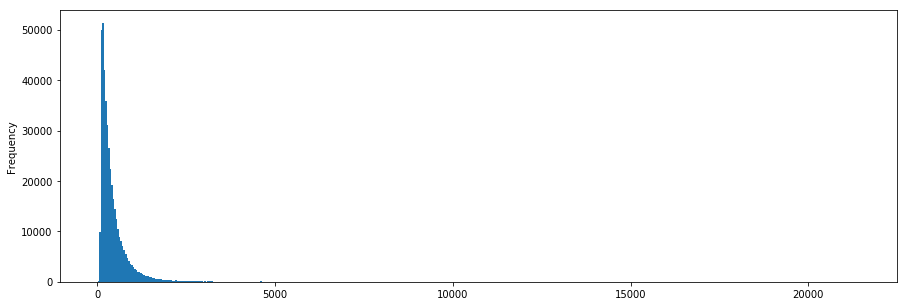

In [183]:
original_df['length'].plot.hist(bins=500,figsize = (15,5))

In [184]:
original_df[original_df['length'] == 21409]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length
21756,290808,B005HG9ESG,A24HWYHR28JJ7A,&#131;&#367;&#142;&#378;&#376; &#969;&#364;&#...,10,11,3,1348272000,An okay filtered municipal tap water with slig...,Fuzzy Wuzzy's Summary:<br />*** Somewhat recom...,21409
66592,496754,B005HG9ET0,A24HWYHR28JJ7A,&#131;&#367;&#142;&#378;&#376; &#969;&#364;&#...,10,11,3,1348272000,An okay filtered municipal tap water with slig...,Fuzzy Wuzzy's Summary:<br />*** Somewhat recom...,21409
175574,455394,B005HG9ERW,A24HWYHR28JJ7A,&#131;&#367;&#142;&#378;&#376; &#969;&#364;&#...,10,11,3,1348272000,An okay filtered municipal tap water with slig...,Fuzzy Wuzzy's Summary:<br />*** Somewhat recom...,21409


In [185]:
original_df[original_df['length'] == 21409]['Text'].iloc[0]

'Fuzzy Wuzzy\'s Summary:<br />*** Somewhat recommended, with reservations and only lukewarm fuzzies.<br /><br />Positives:<br /><br />+ Not too expensive compared to other bottled water, although it is not cheap either.<br /><br />Negatives:<br /><br />- This bottled water product\'s labeling, product descriptions, and health claims are misleading.<br /><br />At first glance, this 1.5-liter bottle of water that I am reviewing looks like another one of the many varieties of bottled water on the market.  There are many kinds of bottled water: "spring water" produced from an underground formation where the groundwater naturally flows up to the Earth\'s surface, "artesian water" obtained from a well that taps into an underground aquifer, "mineral water" produced from a well or spring that naturally contains trace amounts of minerals that some people consider to provide health benefits, "ground/well water" produced from a well that tapes into an aquifer, "sparkling water" from a spring or w

In [186]:
original_df[original_df['length'] >15000]['Text'].iloc[3]

'*********************************************************<br /> UPDATE:  READ THE UPDATE BELOW FIRST. Thanks. (June 15 and August 3, 2012)<br />*********************************************************<br />  I WAS, BUT NO MORE (actively anyway). We have four cats: two ("normals") who eat about anything, one with kidney disease (CRF/CKD) and accompanying reduced appetite, and one that has picky (and weird) tastes.  In the process of trying to find an appetite stimulant for the mom-cat (with CRF/CKD) I tried out several products on her and the others (the kids) as well.<br />Here are the results of this less than scientific (or definitive) survey:<br /><br />  Drs.Foster&Smith Shrimp Snappies Treats (ground to powder)-----------ALL REFUSED.<br />  Freeze-dried powders (Prowl and Ziwi Peak)----------------------------NO EFFECT. All but one (Ms. Picky) ate them.<br />  Seafood juices (tuna, oyster, sardine, etc.)-----------------------------NO EFFECT. All but (same) one ate them.<br />  

#### <font color="red">we need to get rid of this long data as it will effect our model prediction < 2500 in length </font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018FFF4FC080>,
      dtype=object)

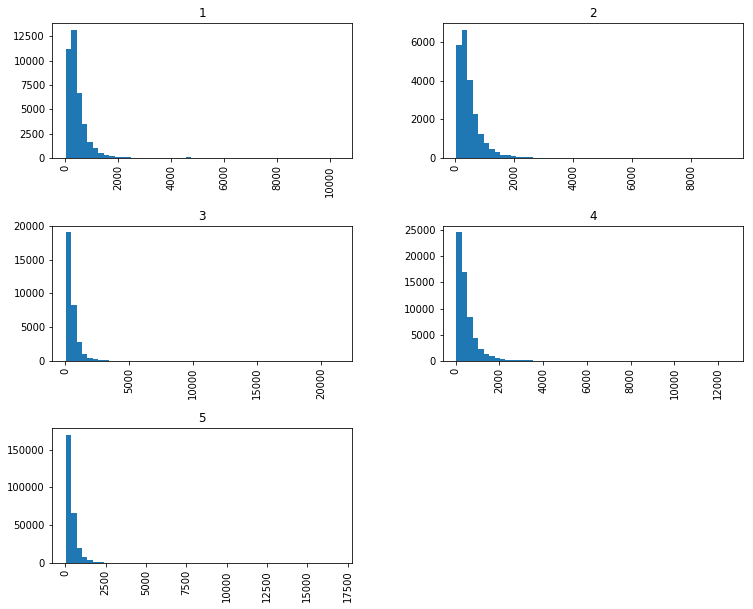

In [187]:
original_df.hist(column='length',by='Score',bins=50,figsize=(12,10))

#### Data Visualization

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018FF976D518>,
      dtype=object)

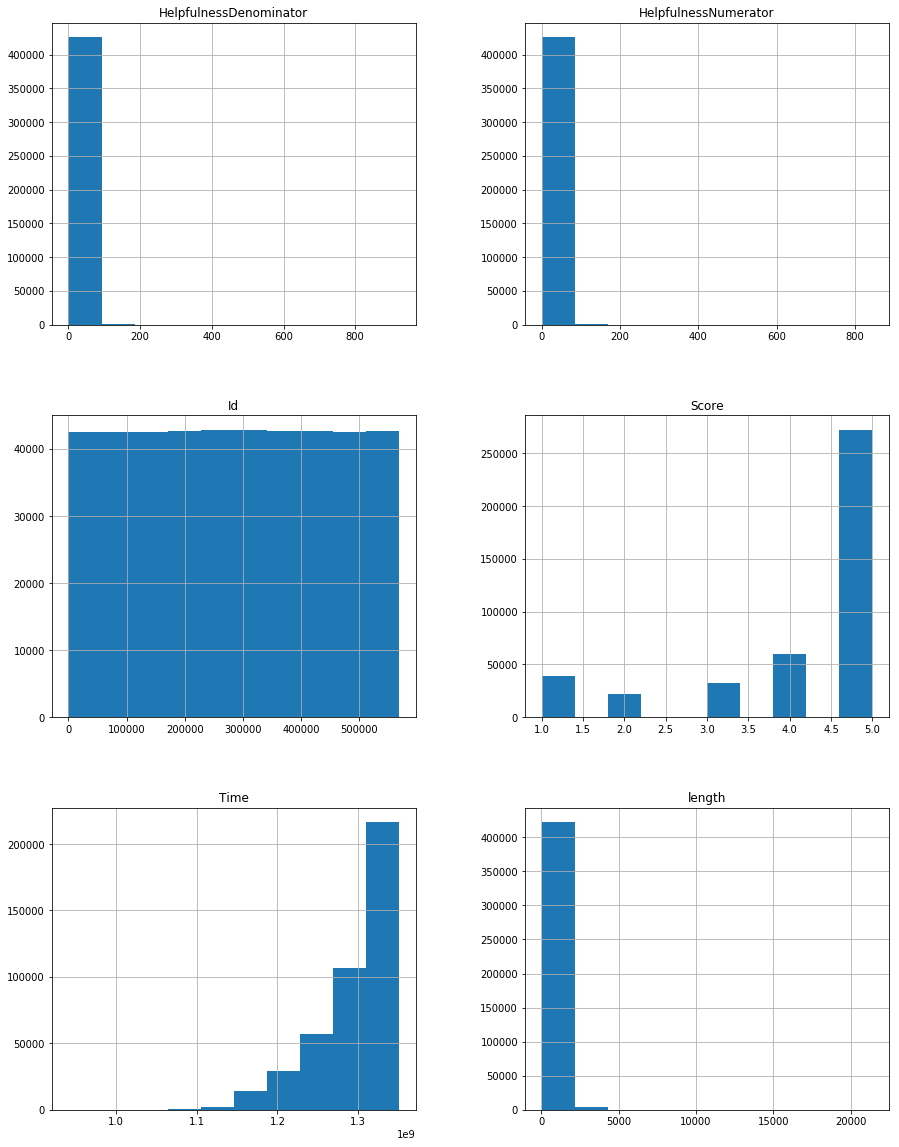

In [188]:
# Visualize original original data
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
original_df.hist(bins=10, ax=ax)

In [189]:
#Groupby by score
original_df.groupby('Score').describe()

Id                                                          \
          count           mean            std   min       25%       50%   
Score                                                                     
1       39193.0  282904.535606  162865.104452   2.0  142706.0  283604.0   
2       22353.0  280643.847850  164445.543153  68.0  137929.0  278032.0   
3       31993.0  279476.092333  165426.046308  46.0  136097.0  274969.0   
4       60309.0  281941.848729  164780.725409   3.0  138600.0  280352.0   
5      272492.0  285890.169021  163781.498091   1.0  144535.5  287247.5   

                          HelpfulnessNumerator            ...          Time  \
            75%       max                count      mean  ...           75%   
Score                                                     ...                 
1      421880.0  568434.0              39193.0  2.747812  ...  1.334275e+09   
2      422521.0  568451.0              22353.0  1.864627  ...  1.333757e+09   
3      424951.0  568423.0              31993.0  1.733817  ...  1.333411e+09   
4      424999.0  568421.0              60309.0  1.379910  ...  1.333325e+09   
5      427344.5  568454.0             272492.0  1.654540  ...  1.332029e+09   

                       length                                              \
                max     count        mean         std   min    25%    50%   
Score                                                                       
1      1.351210e+09   39193.0  476.305310  511.875562  12.0  202.0  338.0   
2      1.351210e+09   22353.0  489.160650  449.449918  33.0  212.0  358.0   
3      1.351210e+09   31993.0  518.617635  516.789152  32.0  214.0  373.0   
4      1.351210e+09   60309.0  496.795652  485.861557  35.0  196.0  347.0   
5      1.351210e+09  272492.0  401.742767  408.956573  18.0  170.0  277.0   

                       
         75%      max  
Score                  
1      563.0  10327.0  
2      606.0   9295.0  
3      653.0  21409.0  
4      625.0  12518.0  
5      480.0  16952.0  

[5 rows x 40 columns]

In [190]:
# re-arranging columns to make the class column the last one
original_df = original_df[['Id','ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score']]

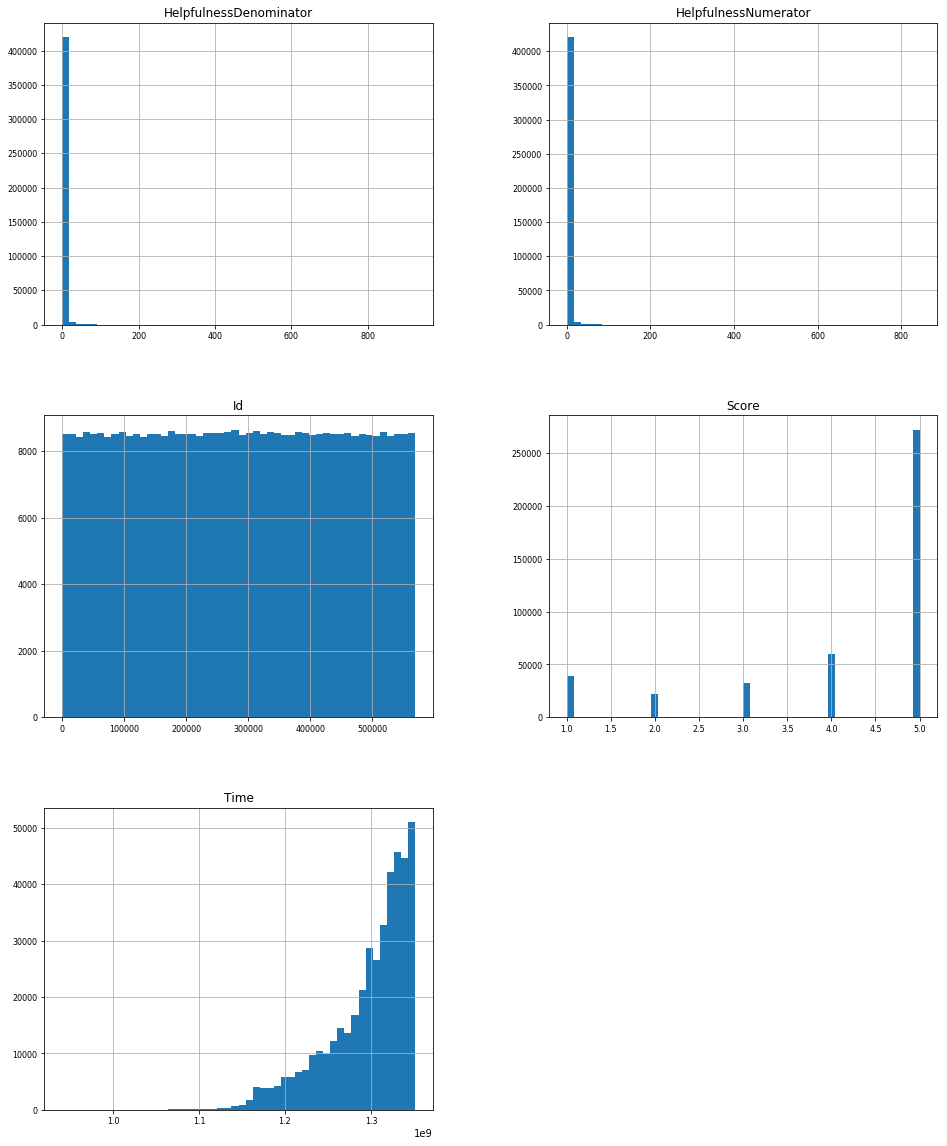

In [191]:
df_num = original_df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

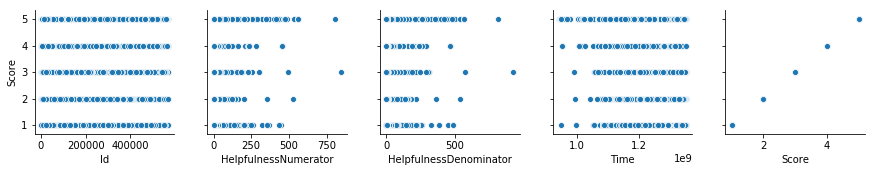

In [192]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['Score'])

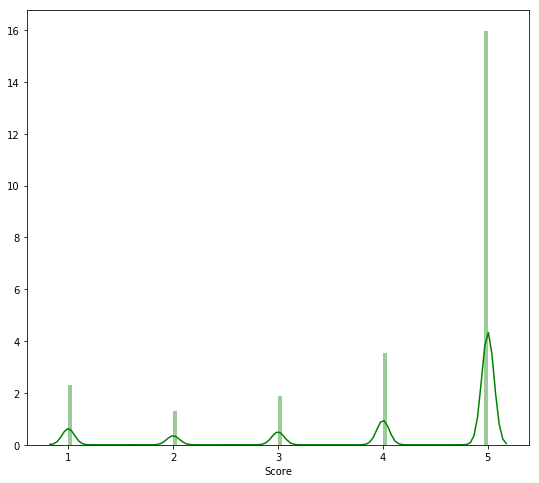

In [193]:
plt.figure(figsize=(9, 8))
sns.distplot(original_df['Score'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [194]:
import operator

# here we calculate the correlations of all of our numeric attributes. we ignore attributes with correlation of 0.
individual_features_df = []
for i in range(0, len(df_num.columns) - 1): # -1 because last column is score.
    tmpDf = df_num[[df_num.columns[i], 'Score']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['Score'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

HelpfulnessDenominator: -0.07724218886413477
           Time: -0.06318610909302598
HelpfulnessNumerator: -0.022805615821503325
             Id: 0.009985657224340675


In [195]:
# here we print any numeric attribute that has a strong correlation with our score (>0.5)
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.5]
print("There is {} strongly correlated numerical values with Score:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated numerical values with Score:
[]


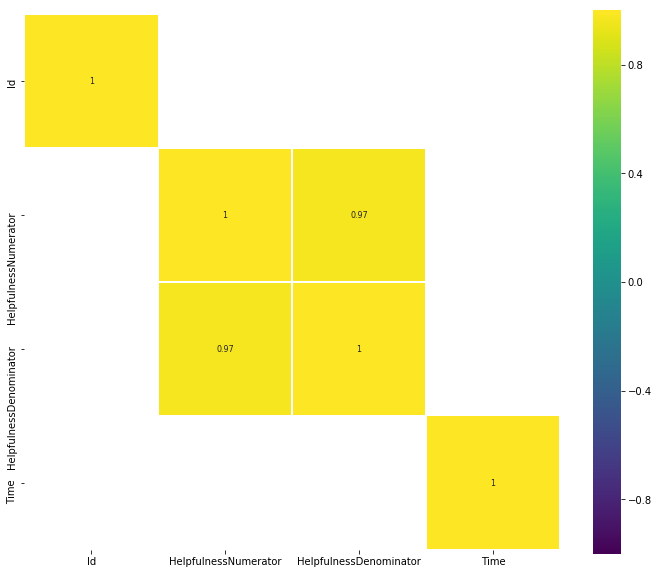

In [196]:
# exploring inter-correlation among numeric attributes.
corr = df_num.drop('Score', axis=1).corr() # We already examined Score correlations
plt.figure(figsize=(12, 10))

# here we finally plot a correlation matrix for our numeric attributes.
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [197]:
# now we move onto our categorical (non numeric) attributes. 
df_not_num = original_df.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 5 non numerical features including:
['ProductId', 'UserId', 'ProfileName', 'Summary', 'Text']


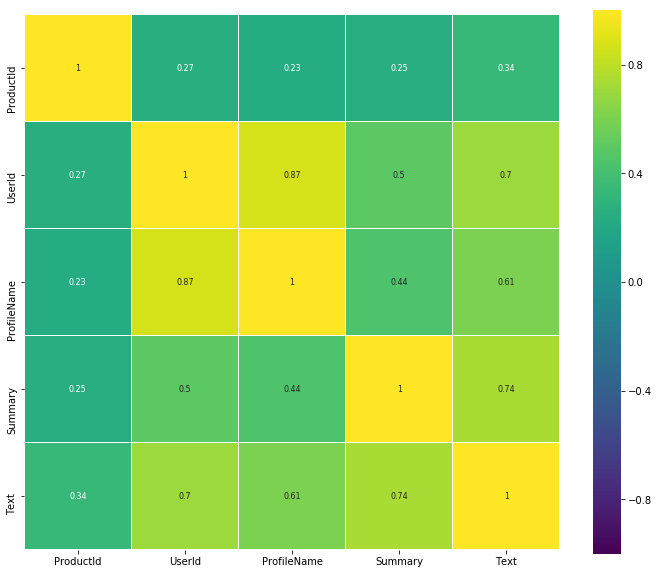

In [198]:
# Categorical attributes inter-correlation
plt.figure(figsize=(12, 10))
corr = df_not_num.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

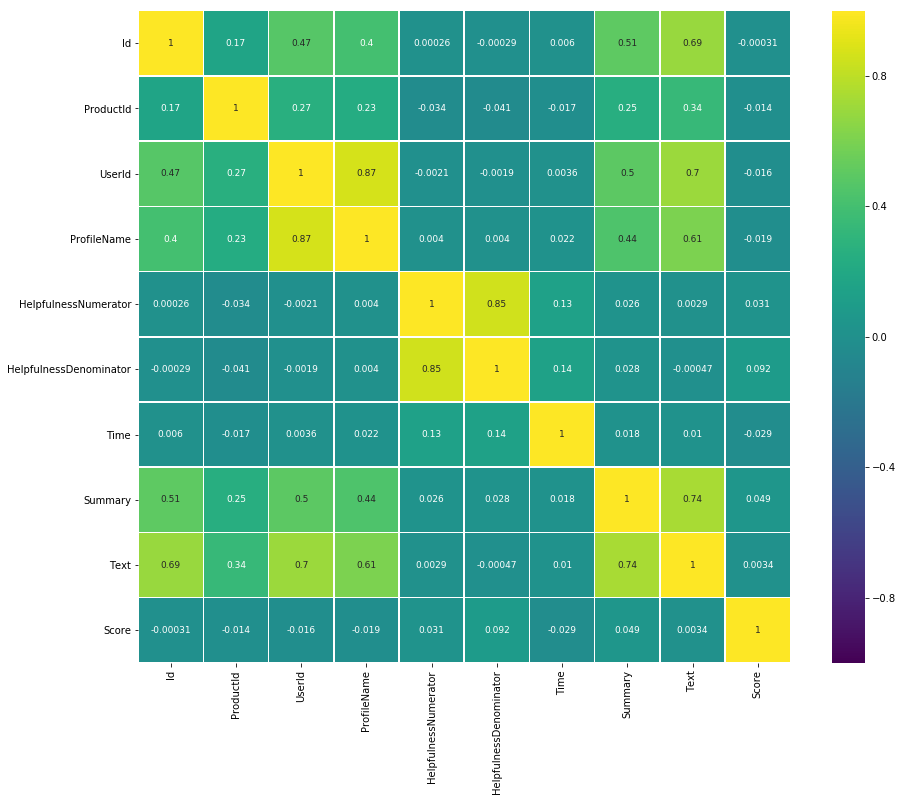

In [199]:
# we finally print a correlation matrix that includes our factorized categorical values as well as the numerical attributes.
plt.figure(figsize=(15, 12))
corr = original_df.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.5,
            annot=True, annot_kws={"size": 9}, square=True)

# 2-Text Processing and Normalization: (20%)
Thoroughly experiment with different text processing and normalization alternatives. Explain the
trade-off and benefits of using each and justify their effectiveness for the current data set. 

#### Extract Needed Columns

In [200]:
# Get rid of un needed columns

df_required_columns = neededColumnsOnly(original_df, ['ProductId','Score','Summary','Text'])

In [201]:
df_required_columns.head(10)

,ProductId,Summary,Text,Score
0,B0034EDLS2,Very Good,I received this product early from the seller!...,5
1,B001I7HJE4,"Organic, Kosher, Tasty Assortment of Premium T...",*****<br />Numi's Collection Assortment Melang...,5
2,B000LKTB90,"excellent gluten-free spaghetti: great taste, ...","I was very careful not to overcook this pasta,...",5
3,B001HXJPS2,Lindt is Lindt,Buying this multi-pack I was misled by the pic...,5
4,B006H34CUS,YUM!!!!!,These bars are so good! I loved them warmed up...,5
5,B004728MI4,Delicious,"I love these chips, I buy the 24 pack once a m...",5
6,B001BZ5EFE,Tastes great and it's organic!!,I'm a huge fan of eating cereal for breakfast....,5
7,B0001AVRQK,Poor taste,I was really disappointed with the Sorghum we ...,2
8,B005GV9RZC,Better than US Instant Coffee,A friend who has gone to Korea gave me a coupl...,3
9,B004FEN3GK,Hard not to like!,No need for plastic baggies or sloppy tin foil...,4


#### Remove Nulls

In [202]:
# Get list of columns containing null values

list_columns_with_nulls = columns_with_nulls(df_required_columns, 'ProductId')

In [203]:
list_columns_with_nulls

['Summary']

In [204]:
# Replace null values with empty string

df_without_nulls = remove_nulls(df_required_columns, list_columns_with_nulls)

In [207]:
df_without_nulls.head()

,ProductId,Summary,Text,Score
0,B0034EDLS2,Very Good,I received this product early from the seller!...,5
1,B001I7HJE4,"Organic, Kosher, Tasty Assortment of Premium T...",*****<br />Numi's Collection Assortment Melang...,5
2,B000LKTB90,"excellent gluten-free spaghetti: great taste, ...","I was very careful not to overcook this pasta,...",5
3,B001HXJPS2,Lindt is Lindt,Buying this multi-pack I was misled by the pic...,5
4,B006H34CUS,YUM!!!!!,These bars are so good! I loved them warmed up...,5


In [208]:
# double check if removed

columns_with_nulls(df_without_nulls, 'ProductId')

[]

#### Remove Html Tags

In [209]:
# Get list of columns containing html tags

list_columns_with_html = columns_with_html(df_without_nulls)

In [210]:
list_columns_with_html

['Text']

In [211]:
# example of html tag in text column

df_without_nulls.loc[1]['Text']

'*****<br />Numi\'s Collection Assortment Melange includes:<br />5 Herbal Teas (caffeine-free, also called "teasans"):<br />* Dry Desert Lime: Lime Herbal Teasan<br />* Fields of Gold: Lemongrass Herbal Teasan<br />* Red Mellow Bush: Rooibos Herbal Teasan<br />* Bushmen\'s Brew: Honeybush Herbal Teasan<br />* Simply Mint: Moroccan Mint<br /><br />2 Green Teas (lower in caffeine):<br />* Temple of Heaven: Gunpowder Green Tea<br />* Monkey King: Jasmine Green Tea<br /><br />2 Black Teas (contain caffeine):<br />* Chinese Breakfast: Yunnan Black Tea<br />* Smoky Tarry: Lapsang Souchong Black Tea<br /><br />This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings.<br /><br />On the box, the manufacturer writes: "From mist-covered mountains to sun-drenched deserts

In [212]:
df_without_html = df_without_nulls.copy()

In [213]:
# Get rid of html tags 
df_without_html['Text'] = df_without_html['Text'].apply(remove_html_tags)

In [214]:
df_without_html.loc[1]['Text']

'***** Numi\'s Collection Assortment Melange includes: 5 Herbal Teas (caffeine-free, also called "teasans"): * Dry Desert Lime: Lime Herbal Teasan * Fields of Gold: Lemongrass Herbal Teasan * Red Mellow Bush: Rooibos Herbal Teasan * Bushmen\'s Brew: Honeybush Herbal Teasan * Simply Mint: Moroccan Mint 2 Green Teas (lower in caffeine): * Temple of Heaven: Gunpowder Green Tea * Monkey King: Jasmine Green Tea 2 Black Teas (contain caffeine): * Chinese Breakfast: Yunnan Black Tea * Smoky Tarry: Lapsang Souchong Black Tea This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings. On the box, the manufacturer writes: "From mist-covered mountains to sun-drenched deserts to fertile fields, we proudly bring you our tea palette. The flavors range from smooth earthiness,

#### Merge Summary and Text in review column

In [215]:
# final dataframe preparation

final_df = merge_summary_text(df_without_html)

In [216]:
final_df.head(10)

,Score,review
0,5,Very Good I received this product early from t...
1,5,"Organic, Kosher, Tasty Assortment of Premium T..."
2,5,"excellent gluten-free spaghetti: great taste, ..."
3,5,Lindt is Lindt Buying this multi-pack I was mi...
4,5,YUM!!!!! These bars are so good! I loved them ...
5,5,"Delicious I love these chips, I buy the 24 pac..."
6,5,Tastes great and it's organic!! I'm a huge fan...
7,2,Poor taste I was really disappointed with the ...
8,3,Better than US Instant Coffee A friend who has...
9,4,Hard not to like! No need for plastic baggies ...


In [217]:
len(final_df)

426340

#### Remove Outliers

In [251]:
final_df = remove_outliers(final_df,3000)

424844


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#####  Correct accented letters

In [229]:
#check if accent exist
text_html = final_df['review'].str.find('é')
text_html = text_html[text_html != -1]

In [230]:
text_html.head(10)

864       173
3467      371
4554     1236
4590     1494
7852       15
9339      123
12255     112
14951    1547
15712      61
16072     471
Name: review, dtype: int64

In [245]:
# we need to find new row number of nescafe
#final_df['review'].iloc[15701] #nescafé  is found

In [246]:
#remove accents
#final_df['review'] = final_df['review'].apply(correct_accent)

In [247]:
#double check if removed
#final_df['review'].iloc[15712]

##### Remove Punctuations

In [250]:
final_df.head(10)

,Score,review
0,5,Very Good I received this product early from t...
1,5,Organic Kosher Tasty Assortment of Premium T...
2,5,excellent gluten free spaghetti great taste ...
3,5,Lindt is Lindt Buying this multi pack I was mi...
4,5,YUM These bars are so good I loved them ...
5,5,Delicious I love these chips I buy the 24 pac...
6,5,Tastes great and it's organic I'm a huge fan...
7,2,Poor taste I was really disappointed with the ...
8,3,Better than US Instant Coffee A friend who has...
9,4,Hard not to like No need for plastic baggies ...


In [252]:
#remove punctuations
final_df = final_df.copy()
final_df['review'] = final_df['review'].apply(remove_punctuations)

In [253]:
final_df.iloc[1]["review"]

"Organic  Kosher  Tasty Assortment of Premium Teas   Teasans       Numi's Collection Assortment Melange includes  5 Herbal Teas  caffeine free  also called  teasans      Dry Desert Lime  Lime Herbal Teasan   Fields of Gold  Lemongrass Herbal Teasan   Red Mellow Bush  Rooibos Herbal Teasan   Bushmen's Brew  Honeybush Herbal Teasan   Simply Mint  Moroccan Mint 2 Green Teas  lower in caffeine     Temple of Heaven  Gunpowder Green Tea   Monkey King  Jasmine Green Tea 2 Black Teas  contain caffeine     Chinese Breakfast  Yunnan Black Tea   Smoky Tarry  Lapsang Souchong Black Tea This is a total of nine different teas  two tea bags of each one in each box  Numi teas are known for their high quality  organic and kosher ingredients  and in my opinion  are some of the tastiest and best teas I have ever tried  They do not include artificial ingredients or flavorings  On the box  the manufacturer writes   From mist covered mountains to sun drenched deserts to fertile fields  we proudly bring you 

##### Expand Short Words

In [254]:
final_df['review'] = final_df['review'].apply(expand_words)

In [255]:
final_df.iloc[1]["review"]

"Organic  Kosher  Tasty Assortment of Premium Teas   Teasans       Numi's Collection Assortment Melange includes  5 Herbal Teas  caffeine free  also called  teasans      Dry Desert Lime  Lime Herbal Teasan   Fields of Gold  Lemongrass Herbal Teasan   Red Mellow Bush  Rooibos Herbal Teasan   Bushmen's Brew  Honeybush Herbal Teasan   Simply Mint  Moroccan Mint 2 Green Teas  lower in caffeine     Temple of Heaven  Gunpowder Green Tea   Monkey King  Jasmine Green Tea 2 Black Teas  contain caffeine     Chinese Breakfast  Yunnan Black Tea   Smoky Tarry  Lapsang Souchong Black Tea This is a total of nine different teas  two tea bags of each one in each box  Numi teas are known for their high quality  organic and kosher ingredients  and in my opinion  are some of the tastiest and best teas I have ever tried  They do not include artificial ingredients or flavorings  On the box  the manufacturer writes   From mist covered mountains to sun drenched deserts to fertile fields  we proudly bring you 

##### Remove remaining apostrophe

In [256]:
final_df['review'] = final_df['review'].apply(remove_apostrophe)

In [257]:
final_df.iloc[1]["review"]

'Organic  Kosher  Tasty Assortment of Premium Teas   Teasans       Numi s Collection Assortment Melange includes  5 Herbal Teas  caffeine free  also called  teasans      Dry Desert Lime  Lime Herbal Teasan   Fields of Gold  Lemongrass Herbal Teasan   Red Mellow Bush  Rooibos Herbal Teasan   Bushmen s Brew  Honeybush Herbal Teasan   Simply Mint  Moroccan Mint 2 Green Teas  lower in caffeine     Temple of Heaven  Gunpowder Green Tea   Monkey King  Jasmine Green Tea 2 Black Teas  contain caffeine     Chinese Breakfast  Yunnan Black Tea   Smoky Tarry  Lapsang Souchong Black Tea This is a total of nine different teas  two tea bags of each one in each box  Numi teas are known for their high quality  organic and kosher ingredients  and in my opinion  are some of the tastiest and best teas I have ever tried  They do not include artificial ingredients or flavorings  On the box  the manufacturer writes   From mist covered mountains to sun drenched deserts to fertile fields  we proudly bring you 

#### Remove Numbers

In [262]:
final_df['review'] = final_df['review'].apply(remove_numbers)

#### Remove Extra Spaces

In [263]:
final_df['review'] = final_df['review'].apply(remove_extra_space)

In [264]:
final_df.iloc[1]["review"]

'Organic Kosher Tasty Assortment of Premium Teas Teasans Numi s Collection Assortment Melange includes Herbal Teas caffeine free also called teasans Dry Desert Lime Lime Herbal Teasan Fields of Gold Lemongrass Herbal Teasan Red Mellow Bush Rooibos Herbal Teasan Bushmen s Brew Honeybush Herbal Teasan Simply Mint Moroccan Mint Green Teas lower in caffeine Temple of Heaven Gunpowder Green Tea Monkey King Jasmine Green Tea Black Teas contain caffeine Chinese Breakfast Yunnan Black Tea Smoky Tarry Lapsang Souchong Black Tea This is a total of nine different teas two tea bags of each one in each box Numi teas are known for their high quality organic and kosher ingredients and in my opinion are some of the tastiest and best teas I have ever tried They do not include artificial ingredients or flavorings On the box the manufacturer writes From mist covered mountains to sun drenched deserts to fertile fields we proudly bring you our tea palette The flavors range from smooth earthiness and light 

In [265]:
final_df.head(10)

,Score,review
0,5,Very Good I received this product early from t...
1,5,Organic Kosher Tasty Assortment of Premium Tea...
2,5,excellent gluten free spaghetti great taste gr...
3,5,Lindt is Lindt Buying this multi pack I was mi...
4,5,YUM These bars are so good I loved them warmed...
5,5,Delicious I love these chips I buy the pack on...
6,5,Tastes great and it is organic I am a huge fan...
7,2,Poor taste I was really disappointed with the ...
8,3,Better than US Instant Coffee A friend who has...
9,4,Hard not to like No need for plastic baggies o...


####  transform to lower case

In [266]:
final_df['review'] = final_df['review'].apply(toLower)

In [267]:
final_df.iloc[1]["review"]

'organic kosher tasty assortment of premium teas teasans numi s collection assortment melange includes herbal teas caffeine free also called teasans dry desert lime lime herbal teasan fields of gold lemongrass herbal teasan red mellow bush rooibos herbal teasan bushmen s brew honeybush herbal teasan simply mint moroccan mint green teas lower in caffeine temple of heaven gunpowder green tea monkey king jasmine green tea black teas contain caffeine chinese breakfast yunnan black tea smoky tarry lapsang souchong black tea this is a total of nine different teas two tea bags of each one in each box numi teas are known for their high quality organic and kosher ingredients and in my opinion are some of the tastiest and best teas i have ever tried they do not include artificial ingredients or flavorings on the box the manufacturer writes from mist covered mountains to sun drenched deserts to fertile fields we proudly bring you our tea palette the flavors range from smooth earthiness and light 

#### remove stop words

In [268]:
final_df['review'] = final_df['review'].apply(remove_stop_words)

In [269]:
final_df.iloc[1]["review"]

'organic kosher tasty assortment premium teas teasans numi collection assortment melange includes herbal teas caffeine free also called teasans dry desert lime lime herbal teasan fields gold lemongrass herbal teasan red mellow bush rooibos herbal teasan bushmen brew honeybush herbal teasan simply mint moroccan mint green teas lower caffeine temple heaven gunpowder green tea monkey king jasmine green tea black teas contain caffeine chinese breakfast yunnan black tea smoky tarry lapsang souchong black tea total nine different teas two tea bags one box numi teas known high quality organic kosher ingredients opinion tastiest best teas ever tried not include artificial ingredients flavorings box manufacturer writes mist covered mountains sun drenched deserts fertile fields proudly bring tea palette flavors range smooth earthiness light floral scents refreshingly sweet sour notes share recollection ancient one tamed fire water coexist harmoniously steeped gifts nature since distant past peop

####  remove extra spaces again

In [270]:
final_df['review'] = final_df['review'].apply(remove_extra_space)

In [271]:
final_df.head(10)

,Score,review
0,5,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...
2,5,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...
5,5,delicious love chips buy pack month bags right...
6,5,tastes great organic huge fan eating cereal br...
7,2,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...
9,4,hard not like no need plastic baggies sloppy t...


## 1.3 Cleaned data Explore and Visualize

#### Visualize score count

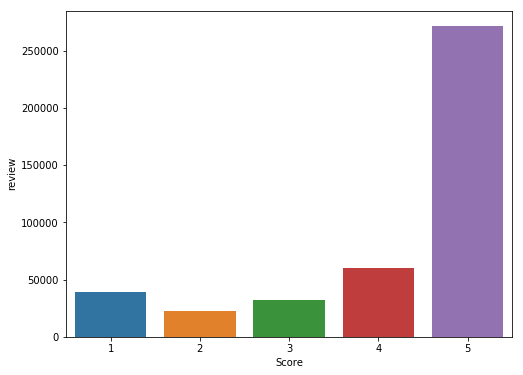

In [272]:
visualize_score_count(final_df)

####  Describe Score Data

In [273]:
#Groupby Score and describe()
final_df.groupby('Score').describe()

review                                                                
        count  unique                                                top freq
Score                                                                        
1       38912   28354  warning contains menadione according manufactu...   30
2       22280   16222  personal preference hoped tea would taste bett...   23
3       31887   23187  i pass not enough flavor murky brown color lac...   22
4       60069   43646  stash chamomile herbal tea stash chamomile her...   30
5      271696  196479  fantastic food good cat health pet food indust...   37

####  Analyze finding

#### we found that not all are unique. so we investigate further for uniqness

In [274]:
final_df.groupby('review').agg('count')

,Score
review,
a add little organic manuka honey half cup milk microwave minute enjoy keeps eating high calorie bagel cream cheese etc much healthier run mill cereals read less sugar,1
a adjustments necessary love nutrition little strong month old started solids months exclusively bf first couple bits gagged quite bit simply stuck little food processer wal mart added banana wolfed like nothing applesauce works well also definetly buy more,3
a afterlife success many movies dealt figure death dead good angel clarence wonderful life brad pitt abysmal turn death meet joe black however tim burton presented world interestng look dead beetlejuice first moments movie barbara adam maitland go town die oddest possible way return thier house find selves confined premises thier leaving sends strange desert world populated multi layered sandworms eventually find dead must remain home years would not bad not family nyc artisans moves remodels place consulting thier caseworker juno sylvia sidney chain smoking best hire bio exorcist betelguese pronouced beetlejuice hence title agrees help unfortunately maitlands beetlejuice extremely po ed demon refuses return underworld visuals special effects movie completely stunning micheal keaton gives performance must blast play beetlejuice beer swilling cussing moral majority worst nightmare superpowers beetlejuice one tim burton best works something proud of,3
a appealing pate price got feeling opening serving jar cat food quite pleased taste texture pate surprisingly subtle mix flavors strikes right balance earthiness mushrooms smoky marsala wine rich butteriness pate really enjoy pate carr poppy sesame crackers going serve guests recommend carefully spreading crackers stirring serving dish ahead time avoid shaped chunks turning people off,1
a authentic moroccan spice blend many ethnic spice mixtures no one recipe ras el hanout family spice merchant highly treasured guarded version traditional blend particular product high quality arrived fresh not always case spices purchased line ras el hanout starts strong curry like flavors betrays indian origins followed subtle traditional african flavors nigella rosebuds although pleased blend think priced shop spices ethnic markets mostly indian middle eastern find mixtures not fresh really affordable using mixture new tagine use often enough seek african grocery store similar product price moroccan expatriates willing pay not live near city large enough type store think best ras el hanout available line matter fact tangine cookbook bought recently singled zamouri source delicious exotic blend tagines couscous delicious recipes moroccan one pot cooking emile henry flame top quart tagine red harissa paste oz zamouri spices,1
a authentic sriracha americans familiar huey fong sriracha hot chili sauce version sriracha sauce jokingly called screaming chicken hot sauce see asian restaurants huey fong version fairly thick somewhat sweet makes palatable american tastes came across shark sriracha somewhat accident quickly remembered wide variety sauces cuisines vary region remind matter taste preference shark sriracha quite shocking prepared traditional thai manner meaning runnier piquant many americans may put foreign language labeling fearful contents not worry not hot think many things put kicking tried sriracha sauce not hot fact nice touch sweetness makes great addition thai chinese dishes truthfully nowhere near hot tabasco sauce scoville scale hotness ranks range making medium tabasco next level self confessed hot head hot sauce lover admit shark sriracha much blendable consistency works easier cooking blends well many asian dishes typically love northern thai food shark sriracha works well with szechwan well shark sriracha gives nice pop hot without overpowering like hot sauces truly hot thai chilies rate scoville scale something bit bland taste usually bit shark sriracha gets mouth watering not let fear unknown scare shark sriracha not know missing,1
a awesome

#### visualize one of the duplicate data

In [275]:
t = final_df['review'].str.find('I only used two maybe three tea bags and got pregnan')
t = t[t != -1]

In [276]:
t

Series([], Name: review, dtype: int64)

In [277]:
final_df.loc[43935]['review']

'i used two maybe three tea bags got pregnant not drink pregnancy not bad taste not big tea fan either'

In [278]:
final_df.loc[187578]['review']

'i used two maybe three tea bags got pregnant not drink pregnancy not bad taste not big tea fan either'

In [279]:
final_df.loc[306678]['review']

'i used two maybe three tea bags got pregnant not drink pregnancy not bad taste not big tea fan either'

#### check initial row count

In [280]:
final_df.count()

Score     424844
review    424844
dtype: int64

####  Remove Duplicates

In [281]:
final_df.drop_duplicates(keep="first",inplace=True)

#### check new row count

In [282]:
final_df.count()

Score     307888
review    307888
dtype: int64

In [283]:
final_df.groupby('Score').describe()

review                                                                
        count  unique                                                top freq
Score                                                                        
1       28354   28354  dog would not eat nice package looks good look...    1
2       16222   16222  expired beans arrived promptly ground brewed u...    1
3       23187   23187  tastes like hay love davidson teas not one top...    1
4       43646   43646  yummy got sample raisin oatmeal cookie influen...    1
5      196479  196479  try popcorn husband loved seasoning living pol...    1

In [284]:
final_df.head(10)

,Score,review
0,5,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...
2,5,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...
5,5,delicious love chips buy pack month bags right...
6,5,tastes great organic huge fan eating cereal br...
7,2,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...
9,4,hard not like no need plastic baggies sloppy t...


In [285]:
final_df.iloc[124]['review']

'not bad using coffeemate chocolate creamer not bad use coffeemate chocolate creamer still like swiss mix made milk little better far k cups go milk chocolate coffeemate chocolate creamer not bad currently less cups'

# 2-Text Processing and Normalization: (20%)
Thoroughly experiment with different text processing and normalization alternatives. Explain the
trade-off and benefits of using each and justify their effectiveness for the current data set. 

####  Extract part of final data

In [286]:
final_df_sub = final_df.head(10).copy()

In [287]:
final_df_sub.head(10)

,Score,review
0,5,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...
2,5,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...
5,5,delicious love chips buy pack month bags right...
6,5,tastes great organic huge fan eating cereal br...
7,2,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...
9,4,hard not like no need plastic baggies sloppy t...


#### Tokenize Data

In [288]:
final_df_sub['token'] = final_df_sub['review'].apply(tokeniz)

In [289]:
final_df_sub.head(10)

,Score,review,token
0,5,very good received product early seller tastey...,"[very, good, received, product, early, seller,..."
1,5,organic kosher tasty assortment premium teas t...,"[organic, kosher, tasty, assortment, premium, ..."
2,5,excellent gluten free spaghetti great taste gr...,"[excellent, gluten, free, spaghetti, great, ta..."
3,5,lindt lindt buying multi pack misled picture w...,"[lindt, lindt, buying, multi, pack, misled, pi..."
4,5,yum bars good loved warmed definitely think gr...,"[yum, bars, good, loved, warmed, definitely, t..."
5,5,delicious love chips buy pack month bags right...,"[delicious, love, chips, buy, pack, month, bag..."
6,5,tastes great organic huge fan eating cereal br...,"[tastes, great, organic, huge, fan, eating, ce..."
7,2,poor taste really disappointed sorghum purchas...,"[poor, taste, really, disappointed, sorghum, p..."
8,3,better us instant coffee friend gone korea gav...,"[better, us, instant, coffee, friend, gone, ko..."
9,4,hard not like no need plastic baggies sloppy t...,"[hard, not, like, no, need, plastic, baggies, ..."


#### Stemming Data

In [290]:
# Stem data and calculate time needed for that
start_time = time.time()
final_df_sub['stem'] = final_df_sub['review'].apply(stemm)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.009973287582397461 seconds ---


In [291]:
final_df_sub.head(10)

,Score,review,token,stem
0,5,very good received product early seller tastey...,"[very, good, received, product, early, seller,...",veri good receiv product earli seller tastey g...
1,5,organic kosher tasty assortment premium teas t...,"[organic, kosher, tasty, assortment, premium, ...",organ kosher tasti assort premium tea teasan n...
2,5,excellent gluten free spaghetti great taste gr...,"[excellent, gluten, free, spaghetti, great, ta...",excel gluten free spaghetti great tast great s...
3,5,lindt lindt buying multi pack misled picture w...,"[lindt, lindt, buying, multi, pack, misled, pi...",lindt lindt buy multi pack misl pictur whole h...
4,5,yum bars good loved warmed definitely think gr...,"[yum, bars, good, loved, warmed, definitely, t...",yum bar good love warm definit think great sna...
5,5,delicious love chips buy pack month bags right...,"[delicious, love, chips, buy, pack, month, bag...",delici love chip buy pack month bag right size...
6,5,tastes great organic huge fan eating cereal br...,"[tastes, great, organic, huge, fan, eating, ce...",tast great organ huge fan eat cereal breakfast...
7,2,poor taste really disappointed sorghum purchas...,"[poor, taste, really, disappointed, sorghum, p...",poor tast realli disappoint sorghum purchas us...
8,3,better us instant coffee friend gone korea gav...,"[better, us, instant, coffee, friend, gone, ko...",better us instant coffe friend gone korea gave...
9,4,hard not like no need plastic baggies sloppy t...,"[hard, not, like, no, need, plastic, baggies, ...",hard not like no need plastic baggi sloppi tin...


####  Lemmatizing Data

In [292]:
# Lemmatize data and calculate time needed for that
start_time = time.time()
final_df_sub['lemm'] = final_df_sub['review'].apply(lemm)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.7393684387207031 seconds ---


In [293]:
final_df_sub.head(10)

,Score,review,token,stem,lemm
0,5,very good received product early seller tastey...,"[very, good, received, product, early, seller,...",veri good receiv product earli seller tastey g...,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...,"[organic, kosher, tasty, assortment, premium, ...",organ kosher tasti assort premium tea teasan n...,organic kosher tasty assortment premium tea te...
2,5,excellent gluten free spaghetti great taste gr...,"[excellent, gluten, free, spaghetti, great, ta...",excel gluten free spaghetti great tast great s...,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...,"[lindt, lindt, buying, multi, pack, misled, pi...",lindt lindt buy multi pack misl pictur whole h...,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...,"[yum, bars, good, loved, warmed, definitely, t...",yum bar good love warm definit think great sna...,yum bar good loved warmed definitely think gre...
5,5,delicious love chips buy pack month bags right...,"[delicious, love, chips, buy, pack, month, bag...",delici love chip buy pack month bag right size...,delicious love chip buy pack month bag right s...
6,5,tastes great organic huge fan eating cereal br...,"[tastes, great, organic, huge, fan, eating, ce...",tast great organ huge fan eat cereal breakfast...,taste great organic huge fan eating cereal bre...
7,2,poor taste really disappointed sorghum purchas...,"[poor, taste, really, disappointed, sorghum, p...",poor tast realli disappoint sorghum purchas us...,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...,"[better, us, instant, coffee, friend, gone, ko...",better us instant coffe friend gone korea gave...,better u instant coffee friend gone korea gave...
9,4,hard not like no need plastic baggies sloppy t...,"[hard, not, like, no, need, plastic, baggies, ...",hard not like no need plastic baggi sloppi tin...,hard not like no need plastic baggies sloppy t...


#### Lemmatizing Data using spacy

In [294]:
# Lemmatize data and calculate time needed for that
start_time = time.time()
final_df_sub['spacy_lemm'] = final_df_sub['review'].apply(spacy_lemm)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.056232690811157 seconds ---


In [295]:
final_df_sub.head(10)

,Score,review,token,stem,lemm,spacy_lemm
0,5,very good received product early seller tastey...,"[very, good, received, product, early, seller,...",veri good receiv product earli seller tastey g...,very good received product early seller tastey...,very good receive product early seller tastey ...
1,5,organic kosher tasty assortment premium teas t...,"[organic, kosher, tasty, assortment, premium, ...",organ kosher tasti assort premium tea teasan n...,organic kosher tasty assortment premium tea te...,organic kosher tasty assortment premium tea te...
2,5,excellent gluten free spaghetti great taste gr...,"[excellent, gluten, free, spaghetti, great, ta...",excel gluten free spaghetti great tast great s...,excellent gluten free spaghetti great taste gr...,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...,"[lindt, lindt, buying, multi, pack, misled, pi...",lindt lindt buy multi pack misl pictur whole h...,lindt lindt buying multi pack misled picture w...,lindt lindt buying multi pack mislead picture ...
4,5,yum bars good loved warmed definitely think gr...,"[yum, bars, good, loved, warmed, definitely, t...",yum bar good love warm definit think great sna...,yum bar good loved warmed definitely think gre...,yum bar good love warmed definitely think grea...
5,5,delicious love chips buy pack month bags right...,"[delicious, love, chips, buy, pack, month, bag...",delici love chip buy pack month bag right size...,delicious love chip buy pack month bag right s...,delicious love chip buy pack month bag right s...
6,5,tastes great organic huge fan eating cereal br...,"[tastes, great, organic, huge, fan, eating, ce...",tast great organ huge fan eat cereal breakfast...,taste great organic huge fan eating cereal bre...,taste great organic huge fan eat cereal breakf...
7,2,poor taste really disappointed sorghum purchas...,"[poor, taste, really, disappointed, sorghum, p...",poor tast realli disappoint sorghum purchas us...,poor taste really disappointed sorghum purchas...,poor taste really disappointed sorghum purchas...
8,3,better us instant coffee friend gone korea gav...,"[better, us, instant, coffee, friend, gone, ko...",better us instant coffe friend gone korea gave...,better u instant coffee friend gone korea gave...,well us instant coffee friend go korea give co...
9,4,hard not like no need plastic baggies sloppy t...,"[hard, not, like, no, need, plastic, baggies, ...",hard not like no need plastic baggi sloppi tin...,hard not like no need plastic baggies sloppy t...,hard not like no need plastic baggie sloppy ti...


#### Compare Results

In [296]:
final_df_sub['stem'].iloc[0]

'veri good receiv product earli seller tastey great mid day snack share glutten free friend order product soon'

In [297]:
final_df_sub['lemm'].iloc[0]

'very good received product early seller tastey great mid day snack shared glutten free friend ordering product soon'

In [298]:
final_df_sub['review'].iloc[0]

'very good received product early seller tastey great mid day snack shared glutten free friends ordering product soon'

In [299]:
final_df_sub['spacy_lemm'].iloc[0]

'very good receive product early seller tastey great mid day snack share glutten free friend order product soon'

# 3. Vector space Model and feature representation: (20%)
Experiment with different representation techniques. Document your findings and make
conclusions. Show how choosing n-gram features can influence your results

#### Count Vector

In [300]:
xTrain, y_Train, count_vect, feature_names, count_vectDF = VCM("count", final_df_sub, "stem", "Score")

In [301]:
count_vectDF.head(10)

,absolut,al,also,amazon,amount,ancient,anoth,are,artifici,assort,...,wheat,whole,wife,wonder,would,wrapper,write,year,yum,yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,1,3,...,0,0,0,2,0,0,1,0,0,1
2,1,2,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [302]:
#visualize important features 
count_vectDF.mean(axis=0).sort_values()

absolut      0.1
past         0.1
par          0.1
palett       0.1
packag       0.1
overpow      0.1
overcook     0.1
peopl        0.1
other        0.1
opinion      0.1
old          0.1
nut          0.1
notic        0.1
note         0.1
normal       0.1
order        0.1
nine         0.1
perhap       0.1
plastic      0.1
rang         0.1
quick        0.1
purchas      0.1
proudli      0.1
proof        0.1
pronounc     0.1
pictur       0.1
produc       0.1
previous     0.1
prevent      0.1
pretti       0.1
            ... 
cereal       0.3
fill         0.3
caffein      0.3
buy          0.3
flavor       0.3
sweet        0.3
breakfast    0.3
us           0.4
coffe        0.4
snack        0.4
gluten       0.4
no           0.4
like         0.4
perfect      0.4
tri          0.4
pasta        0.5
herbal       0.5
pack         0.5
organ        0.5
use          0.5
one          0.5
numi         0.6
product      0.6
teasan       0.6
good         0.7
free         0.7
tast         0.9
great        0

#### TFIDF Vector

In [303]:
xTrain2, y_Train2, tfidf_vect, feature_names2, tfidf_vectDF = VCM("tfidf", final_df_sub, "stem", "Score")

In [304]:
tfidf_vectDF.head(10)

,absolut,al,also,amazon,amount,ancient,anoth,are,artifici,assort,...,wheat,whole,wife,wonder,would,wrapper,write,year,yum,yunnan
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
1,0.000000,0.000000,0.035696,0.000000,0.000000,0.04199,0.000000,0.000000,0.04199,0.125971,...,0.000000,0.000000,0.000000,0.083981,0.000000,0.000000,0.04199,0.000000,0.00000,0.04199
2,0.077252,0.154505,0.000000,0.000000,0.000000,0.00000,0.000000,0.077252,0.00000,0.000000,...,0.077252,0.000000,0.077252,0.000000,0.000000,0.000000,0.00000,0.065672,0.00000,0.00000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.193097,0.000000,0.00000,0.000000,...,0.000000,0.193097,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.32186,0.00000
5,0.000000,0.000000,0.000000,0.000000,0.212034,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
6,0.000000,0.000000,0.000000,0.118819,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.186012,0.00000,0.00000
8,0.000000,0.000000,0.094112,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.110709,0.000000,0.00000,0.000000,0.00000,0.00000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.171816,0.00000,0.000000,0.00000,0.00000


In [305]:
#visualize important features 
tfidf_vectDF.mean(axis=0).sort_values()

yunnan       0.004199
mist         0.004199
monkey       0.004199
moroccan     0.004199
earthi       0.004199
mountain     0.004199
natur        0.004199
dri          0.004199
drench       0.004199
distant      0.004199
new          0.004199
nine         0.004199
note         0.004199
differ       0.004199
delight      0.004199
opinion      0.004199
other        0.004199
palett       0.004199
past         0.004199
gift         0.004199
peopl        0.004199
contain      0.004199
encourag     0.004199
mellow       0.004199
ever         0.004199
melang       0.004199
gunpowd      0.004199
harmoni      0.004199
heal         0.004199
heaven       0.004199
               ...   
definit      0.032186
bar          0.032186
influenst    0.032186
right        0.032631
like         0.033386
need         0.034363
delici       0.034440
fill         0.035646
cereal       0.035646
breakfast    0.035898
size         0.036847
chocol       0.038619
pasta        0.038626
bag          0.039619
buy       

### <font color='red'> here we can note that some features although are important, but they are irrelevent in 1 gram and may need bi gram to have good meaning example: taste it can represent either good or bad taste </FONT>

#### Count Vector WITH BIGRAM

In [306]:
xTrain_ngram_2, y_Train_ngram_2, count_vect_ngram_2, feature_names_ngram_2, count_vectDF_ngram_2 = VCM("count", final_df_sub, "stem", "Score",2,2)

In [307]:
count_vectDF_ngram_2.head(10)

,absolut perfect,al dent,also call,also thought,amazon carri,amount flavor,ancient one,anoth proof,are organ,artifici ingredi,...,wife italian,wonder assort,wonder infus,would prefer,wrapper honey,write mist,year old,year previous,yum bar,yunnan black
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,1,...,0,1,1,0,0,1,0,0,0,1
2,1,2,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [308]:
count_vectDF_ngram_2.mean(axis=0).sort_values()

absolut perfect       0.1
proudli bring         0.1
proof import          0.1
pronounc could        0.1
product tremend       0.1
product though        0.1
product soon          0.1
product get           0.1
product free          0.1
product earli         0.1
produc gluten         0.1
problem chocol        0.1
price right           0.1
price perfect         0.1
previous bought       0.1
prevent eat           0.1
pretti good           0.1
prefer well           0.1
poor tast             0.1
pleasant certainli    0.1
plastic baggi         0.1
pictur whole          0.1
perhap larger         0.1
perfect packag        0.1
perfect one           0.1
perfect combin        0.1
perfect big           0.1
peopl sooth           0.1
publix discontinu     0.1
publix sale           0.1
                     ... 
foil wrapper          0.1
foodi year            0.1
great snack           0.1
great organ           0.1
great mid             0.1
great great           0.1
great amount          0.1
floral scent

### <FONT COLOR="RED"> here we can see the combination of taste with other word how it has a clear meaning </FONT>

#### TFIDF WITH BIGRAM

In [316]:
xTrain_ngram_t_2, y_Train_ngram_t_2, count_vect_ngram_t_2, feature_names_ngram_t_2, count_vectDF_ngram_t_2 = VCM("tfidf", final_df_sub, "stem", "Score",2,2)

In [317]:
count_vectDF_ngram_t_2.head(10)

,absolut perfect,al dent,also call,also thought,amazon carri,amount flavor,ancient one,anoth proof,are organ,artifici ingredi,...,wife italian,wonder assort,wonder infus,would prefer,wrapper honey,write mist,year old,year previous,yum bar,yunnan black
0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.066372,0.000,0.000000,0.000000,0.066372,0.000000,0.000000,0.066372,...,0.000000,0.066372,0.066372,0.000,0.000000,0.066372,0.000000,0.000000,0.000000,0.066372
2,0.088426,0.176852,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.088426,0.000000,...,0.088426,0.000000,0.000000,0.000,0.000000,0.000000,0.088426,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.223607,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.280357,0.000000
5,0.000000,0.000000,0.000000,0.000,0.000000,0.196116,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000,0.131622,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.213201,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.164399,0.000000,0.000000,0.000000,0.000000,0.000000


#### Count Vector WITH TRIGRAM

In [318]:
xTrain_ngram_3, y_Train_ngram_3, count_vect_ngram_3, feature_names_ngram_3, count_vectDF_ngram_3 = VCM("count", final_df_sub, "stem", "Score",3,3)

count_vectDF_ngram_3.head(10)

count_vectDF_ngram_3.mean(axis=0).sort_values()

absolut perfect one       0.1
pronounc could serv       0.1
product tremend valu      0.1
product though sweet      0.1
product get star          0.1
product free influenst    0.1
product earli seller      0.1
produc gluten free        0.1
problem chocol delici     0.1
price right consid        0.1
price perfect big         0.1
previous bought vendor    0.1
prevent eat way           0.1
premium tea teasan        0.1
premium tea numi          0.1
prefer well save          0.1
poor tast realli          0.1
pleasant certainli not    0.1
plastic baggi sloppi      0.1
pictur whole hazel        0.1
perhap larger one         0.1
perfect packag snack      0.1
perfect one great         0.1
perfect combin product    0.1
perfect big save          0.1
peopl sooth rous          0.1
pasta wife italian        0.1
pasta product tremend     0.1
pasta make sure           0.1
pasta guest no            0.1
                         ... 
hazel nut anoth           0.1
harmoni steep gift        0.1
hard not l

In [319]:
count_vectDF_ngram_3.head(10)

,absolut perfect one,al dent easi,al dent perfect,also call teasan,also thought littl,amazon carri case,ancient one tame,anoth proof import,are organ produc,artifici ingredi flavor,...,wife italian claim,wonder assort get,wonder infus encourag,would prefer well,wrapper honey maid,write mist cover,year old celiac,year previous bought,yum bar good,yunnan black tea
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,1,...,0,1,1,0,0,1,0,0,0,1
2,1,1,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### TFIDF WITH TRIGRAM

In [320]:
xTrain_ngram_t_3, y_Train_ngram_t_3, count_vect_ngram_t_3, feature_names_ngram_t_3, count_vectDF_ngram_t_3 = VCM("tfidf", final_df_sub, "stem", "Score",3,3)

count_vectDF_ngram_t_3.head(10)

count_vectDF_ngram_t_3.mean(axis=0).sort_values()

yunnan black tea             0.007180
rang smooth earthi           0.007180
free also call               0.007180
qualiti tea not              0.007180
qualiti organ kosher         0.007180
proudli bring tea            0.007180
price perfect big            0.007180
premium tea teasan           0.007180
premium tea numi             0.007180
get not sorri                0.007180
gift natur sinc              0.007180
perfect big save             0.007180
peopl sooth rous             0.007180
gold lemongrass herbal       0.007180
past peopl sooth             0.007180
palett flavor rang           0.007180
other not sampl              0.007180
organ kosher tasti           0.007180
organ kosher ingredi         0.007180
opinion tastiest best        0.007180
one tame fire                0.007180
one box numi                 0.007180
numi tea want                0.007180
numi tea known               0.007180
recollect ancient one        0.007180
numi highli recommend        0.007180
red mellow b

In [321]:
count_vectDF_ngram_t_3.head(10)

,absolut perfect one,al dent easi,al dent perfect,also call teasan,also thought littl,amazon carri case,ancient one tame,anoth proof import,are organ produc,artifici ingredi flavor,...,wife italian claim,wonder assort get,wonder infus encourag,would prefer well,wrapper honey maid,write mist cover,year old celiac,year previous bought,yum bar good,yunnan black tea
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.071796,0.000000,0.000000,0.071796,0.000000,0.000000,0.071796,...,0.000000,0.071796,0.071796,0.000000,0.000000,0.071796,0.000000,0.000000,0.000000,0.071796
2,0.098058,0.098058,0.098058,0.000000,0.000000,0.000000,0.000000,0.000000,0.098058,0.000000,...,0.098058,0.000000,0.000000,0.000000,0.000000,0.000000,0.098058,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.229416,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.288675,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.140028,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.218218,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.130189,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.130189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.171499,0.000000,0.000000,0.000000,0.000000,0.000000


# 4- Model training, selection and hyperparameter tuning and evaluation:(20%)
You should at least experiment with 3 models and show how you can optimize model
parameters using cross validation. For each model discuss your choices of text processing,
representation and features from steps 1-3. 

In [124]:
# Imports and Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string,lxml,bs4,nltk
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from warnings import simplefilter

def dataframe_optimzer(dataframe):
    dataframe.Summary.fillna('', inplace=True)
    dataframe.Text.fillna('', inplace=True)
    dataframe.drop(['Id','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','ProductId'],axis=1,inplace=True)
    #Concatinating TEXT and Summary features as per the DR. example. Which is OK as I didnt find obvoius correlation
    dataframe['text']=dataframe['Summary']+' '+dataframe['Text'] 
    dataframe.drop(['Summary','Text'],axis=1,inplace=True)
    #dataframe['length']=dataframe['text'].str.len() 
    return dataframe

def tokenizer(text):
    no_html = bs4.BeautifulSoup(text,'lxml').get_text()
    no_punctuation = [char for char in no_html if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return no_punctuation

def stemmer(text):
    review = [nltkstemmer.stem(word) for word in text.split()]
    review = ' '.join(review) 
    return review

def lemmatizer(text):
    review = [nltklem.lemmatize(word,'v') for word in text.lower().split()]
    review = ' '.join(review)
    #print(review)
    return review

def classification_report_final (model): 
    y_pred_final = model.predict(df_test_data['text'])
    score_final =accuracy_score(df_test_labels,y_pred_final)
    print('Model score on unseen data',score_final)
    print (classification_report(df_test_labels,y_pred_final))

def dataloading():
    print('Loading reviews...',end='')
    df = pd.read_csv('train.csv')
    print('[ok]')
    print('Loaded {:,} reviews' .format(len(df)))
    
    df=df.head(1000)  # <--- Dataset limiter ia here, Can change
    
    print('applying dataframe optimizer...',end='')
    df = dataframe_optimzer(df)
    print('[OK]')

    print('applying dataframe tokenizer...',end='')
    df['text'].apply(tokenizer)
    print('[OK]')
    return df


nltk.download('wordnet')
nltklem = WordNetLemmatizer()
nltkstemmer = PorterStemmer()
simplefilter(action='ignore', category=Warning)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tamers\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [125]:
df=dataloading()
#Loading test Data
df_test_data = dataframe_optimzer(pd.read_csv("test.csv"))
df_test_labels = pd.read_csv("labels.csv",usecols=['Score'])

Loading reviews...[ok]
Loaded 426,340 reviews
applying dataframe optimizer...[OK]
applying dataframe tokenizer...[OK]


# <font color='red'>REMOVE BELOW CELL BEFORE FINAL RUN</font>

In [126]:
final_df = final_df.head(1000) # ----> REMOVE BEFORE FINAL RUN

In [127]:
df_label = final_df['Score'].copy()
df_data = final_df['review'].copy()

In [128]:
 X_train, X_test, y_train, y_test = train_test_split(df_data, df_label, test_size=0.25, random_state=42)

In [129]:
estimators = [LogisticRegression,MultinomialNB,SGDClassifier]

In [130]:
def create_pipeline(estimator):
    
    pipeline_steps = [
        
        ('cv',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',estimator)
    ]
    
    return Pipeline(pipeline_steps)

In [131]:
#  parameters for Grid Search (CV and TfIdf) - BASE 
param_grid= {}

#Parameters for CountVectorizer
param_grid.update({})
param_grid.update({})
#param_grid.update({})
param_grid.update({})
#Parameters of TFIDF
param_grid.update({})
# Parameters for LR
param_grid_LR = {}
param_grid_LR = {}
param_grid_LR.update(param_grid)
# Parameters for MN
param_grid_MN = {}
param_grid_MN = {}
param_grid_MN.update(param_grid)
#Parameters for SGD here
param_grid_SG={}
param_grid_SG.update(param_grid)


In [132]:
estimators = {
    LogisticRegression : param_grid_LR,
    MultinomialNB : param_grid_MN,
    SGDClassifier : param_grid_SG
}

In [134]:
for estimator,search_param in estimators.items():
    scores=[]
    model = create_pipeline(estimator())
    search=GridSearchCV(model,search_param,n_jobs=-1)
    search.fit(X_train,y_train)
    y_pred = search.predict(X_test)
    score=accuracy_score(y_test,y_pred)
    scores.append(score)
    print(estimator.__name__,'scored',score)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    print (classification_report(y_test,y_pred))
    print('\n')
    print('Cross validation with unseen test data')
    classification_report_final(search)

LogisticRegression scored 0.664
Best parameter (CV score=0.655):
{}
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        21
           4       0.50      0.03      0.06        33
           5       0.67      1.00      0.80       165

    accuracy                           0.66       250
   macro avg       0.23      0.21      0.17       250
weighted avg       0.51      0.66      0.53       250



Cross validation with unseen test data
Model score on unseen data 0.6377274582377528
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13075
           2       0.00      0.00      0.00      7416
           3       0.00      0.00      0.00     10647
           4       0.50      0.00      0.00     20346
           5       0.64      1.00      0.78     90630

    accuracy                  

# 5-Topic Modelling of high and low ratings*: (15%)
Examine the five-star reviews and the one-star reviews separately. Categorize each review into
a set of topics (10-20 topics). Can you infer any particular observations regarding the topics
discussed in the high rated reviews vs. the low rated reviews? Document any other observations
you have gained with this analysis. You may use a smaller subset of the reviews to better
demonstrate your findings.

#### Extracting 1 and 5 subsets

In [324]:
is_score_5 = final_df['Score']==5

In [325]:
df_score_5 = final_df[is_score_5]

In [326]:
df_score_5.head(10)

,Score,review
0,5,very good received product early seller tastey...
1,5,organic kosher tasty assortment premium teas t...
2,5,excellent gluten free spaghetti great taste gr...
3,5,lindt lindt buying multi pack misled picture w...
4,5,yum bars good loved warmed definitely think gr...
5,5,delicious love chips buy pack month bags right...
6,5,tastes great organic huge fan eating cereal br...
10,5,ryvita love product unhappy expiration date pr...
11,5,yummy son loves chocolate got birthday really ...
13,5,oven fry weakness good fried fish age cut frie...


In [327]:
is_score_1 = final_df['Score']==1

In [328]:
df_score_1 = final_df[is_score_1]

In [329]:
df_score_1.head(10)

,Score,review
18,1,plastic taste first coffee tried got keurig di...
31,1,dangerous doggies not buy large german shepher...
49,1,ugh fake food wanted sugar splurge chose short...
55,1,worst products ever chinese never brought prod...
56,1,enormous ripoff nearly twice expensive cost ne...
113,1,these treats make pooch sick cocker spaniel ab...
142,1,fooled years drinking penta water five years w...
153,1,hope like burnt friendly face mr redenbacher m...
173,1,warning contains menadione according manufactu...
176,1,oo long oo short usually not bother write revi...


In [330]:
df_score_5_sub = df_score_5.head(1000).copy()

In [339]:
df_score_1_sub = df_score_1.head(1000).copy()

#### Using NMF

In [331]:
xTrain_5, y_Train_5, count_vect_5, feature_names_5, count_vectDF_5 = VCM("count", df_score_5_sub, "review", "Score")

In [334]:
nmfModel = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf= nmfModel.fit(xTrain_5)

In [335]:
print("nmf.components_.shape: {}".format(nmf.components_.shape))

nmf.components_.shape: (20, 6271)


In [337]:
display_topics_mg(nmf, feature_names_5, 20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
not           coffee        tea           food          salt          
one           cup           organic       cat           river         
get           starbucks     teas          cats          murray        
flavor        vanilla       white         old           store         
would         flavored      numi          canned        small         
eat           cups          spice         no            fingers       
little        taste         flavor        one           time          
want          french        orange        wellness      bowl          
try           blend         green         loves         cooking       
honey         best          black         dry           seems         
found         roast         bags          chicken       table         
since         ground        used          eat           food          
work  

In [340]:
xTrain_1, y_Train_1, count_vect_1, feature_names_1, count_vectDF_1 = VCM("count", df_score_1_sub, "review", "Score")

In [341]:
nmfModel1 = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')

In [343]:
nmf1 = nmfModel1.fit(xTrain_1)

In [344]:
print("nmf.components_.shape: {}".format(nmf1.components_.shape))

nmf.components_.shape: (20, 6766)


In [345]:
display_topics_mg(nmf1, feature_names_1, 20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
not           food          product       like          tea           
buy           cat           flavor        tastes        chai          
could         cats          new           flavor        green         
even          ingredients   beef          try           spice         
money         eat           order         tried         not           
get           dry           still         tasted        leaves        
know          meat          use           even          flavor        
company       vet           see           lemon         use           
it            bad           spicy         different     blend         
waste         pet           nong          really        much          
anything      also          shim          trying        spices        
store         products      packaging     stuff         teas          
right 

#### using LDA

In [379]:
lda = LatentDirichletAllocation(n_components=20, learning_method="online",
                                max_iter=25, random_state=0)

In [380]:
document_topics_5 = lda.fit_transform(xTrain_5)

In [381]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (20, 6271)


In [382]:
display_topics_mg(lda,feature_names_5,20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
oil           cheerios      pouch         tropical      popcorn       
olive         tree          pouches       cytomax       molasses      
tins          tassimo       pills         fruit         pops          
oils          marshmallows  donuts        moles         theater       
virgin        bunny         dunkin        hole          packaging     
zoe           baja          kittens       tunnel        honey         
jug           bonsai        popper        traps         potassium     
massive       disc          warm          mole          daughter      
having        pb            baby          set           poper         
ummmm         uncooked      pillpockets   light         ride          
yourself      kosher        andy          lindt         tbsp          
taster        shape         senseo        black         consume       
decade

In [370]:
lda1 = LatentDirichletAllocation(n_components=20, learning_method="batch",
                                max_iter=25, random_state=0)

In [371]:
document_topics_1 = lda1.fit_transform(xTrain_1)

In [372]:
print("lda.components_.shape: {}".format(lda1.components_.shape))

lda.components_.shape: (20, 6766)


In [373]:
display_topics_mg(lda1,feature_names_1,20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
product       not           not           not           not           
not           product       product       tea           money         
would         taste         even          like          buy           
dog           like          date          taste         taste         
no            water         cup           water         product       
half          no            good          flavor        waste         
post          coconut       expired       would         like          
taste         good          like          sugar         no            
review        order         no            good          would         
one           one           expiration    product       box           
caff          get           coffee        green         love          
pee           even          natural       no            tea           
dogs  

In [362]:
svd5 = TruncatedSVD(n_components=20)

document_topics_5 = svd5.fit(xTrain_5)

print("svd.components_.shape: {}".format(svd5.components_.shape))

display_topics_mg(svd5,feature_names_5,20)

svd.components_.shape: (20, 6271)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
not           coffee        tea           salt          salt          
like          tea           organic       food          great         
great         cup           teas          coffee        product       
good          taste         white         tea           use           
coffee        flavor        numi          cat           store         
taste         starbucks     spice         cup           murray        
one           vanilla       flavor        dog           river         
tea           flavored      orange        river         taste         
product       teas          bags          murray        fingers       
food          cups          black         dogs          cooking       
love          great         used          no            small         
flavor        drink         green         o

In [363]:
svd1 = TruncatedSVD(n_components=20)

document_topics_1 = svd1.fit(xTrain_1)

print("svd.components_.shape: {}".format(svd1.components_.shape))

display_topics_mg(svd1,feature_names_1,20)

svd.components_.shape: (20, 6766)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
not           food          product       like          tea           
product       dog           amazon        tea           chai          
like          product       order         product       not           
taste         cat           new           taste         food          
would         cats          made          flavor        spice         
one           diet          received      good          green         
food          amazon        ordered       would         leaves        
no            science       still         one           amazon        
good          time          beef          sugar         use           
even          dogs          use           no            return        
tea           one           purchase      food          blend         
buy           made          item          t

#### NMF with TFIDF

In [385]:
xTrain_t_5, y_Train_t_5, count_vect_t_5, feature_names_t_5, count_vectDF_t_5 = VCM("tfidf", df_score_5_sub, "review", "Score")

nmfModel_tfidf = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_tfidf= nmfModel_tfidf.fit(xTrain_t_5)

print("nmf.components_.shape: {}".format(nmf_tfidf.components_.shape))

display_topics_mg(nmf_tfidf, feature_names_t_5, 20)

nmf.components_.shape: (20, 6271)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
not           coffee        tea           food          product       
good          cup           green         cat           great         
like          bold          teas          cats          excellent     
one           great         bitter        old           arrived       
flavor        strong        white         canned        use           
taste         cups          drink         chicken       taste         
really        decaf         iced          dry           time          
would         dark          black         wellness      years         
get           starbucks     wonderful     loves         condition     
use           taste         flavor        feeding       really        
also          blend         great         no            service       
eat           good          chai          w

#### Visualizing

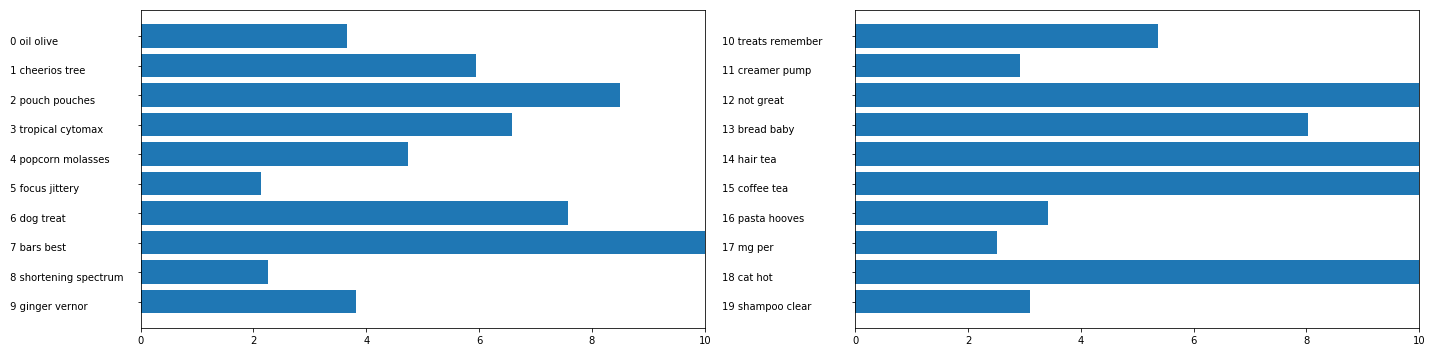

In [383]:
sorting_5 = np.argsort(lda.components_, axis=1)[:, ::-1]

feature_names_5_5 = np.array(feature_names_5)

visualize_topic_modeling(feature_names_5_5, sorting_5, document_topics_5)    